# GoEmotions dataset

In [1]:
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from src.settings import DATA_DIR

DATA_DIR = DATA_DIR.joinpath('goemotions')

df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')

In [3]:
df_train.head()

,text,labels,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        43410 non-null  object
 1   labels      43410 non-null  object
 2   comment_id  43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


In [5]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        5426 non-null   object
 1   labels      5426 non-null   object
 2   comment_id  5426 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5427 entries, 0 to 5426
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        5427 non-null   object
 1   labels      5427 non-null   object
 2   comment_id  5427 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


### Concat splits

In [48]:
df_train['split'] = 'train'
df_dev['split'] = 'val'
df_test['split'] = 'test'
df_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

### Text length

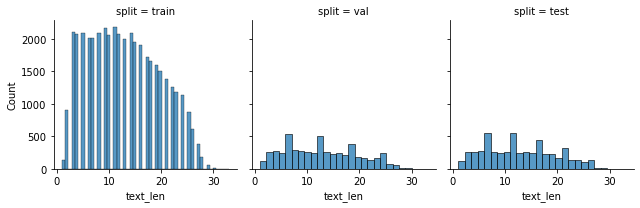

In [49]:
df_all['text_len'] = df_all.text.apply(lambda x: len(x.split(' ')))

g = sns.FacetGrid(df_all, col="split")
g.map(sns.histplot, 'text_len')

In [50]:
df_all.describe()

,text_len
count,54263.000000
mean,12.886295
std,6.734256
min,1.000000
25%,7.000000
50%,12.000000
75%,18.000000
max,33.000000


### Tokenized texts len

In [51]:
from transformers import AutoTokenizer

HUGGINGFACE_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_NAME, do_lower_case=True)

texts = df_all['text'].values.tolist()

text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']

df_all['tok_len'] = lengths
df_all.head()

,text,labels,comment_id,split,text_len,tok_len
0,My favourite food is anything I didn't have to...,27,eebbqej,train,11,16
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,train,20,25
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,train,6,10
3,To make her feel threatened,14,ed7ypvh,train,5,7
4,Dirty Southern Wankers,3,ed0bdzj,train,3,7


In [53]:
df_all.describe()

,text_len,tok_len
count,54263.000000,54263.000000
mean,12.886295,19.630724
std,6.734256,8.923450
min,1.000000,3.000000
25%,7.000000,12.000000
50%,12.000000,19.000000
75%,18.000000,26.000000
max,33.000000,359.000000


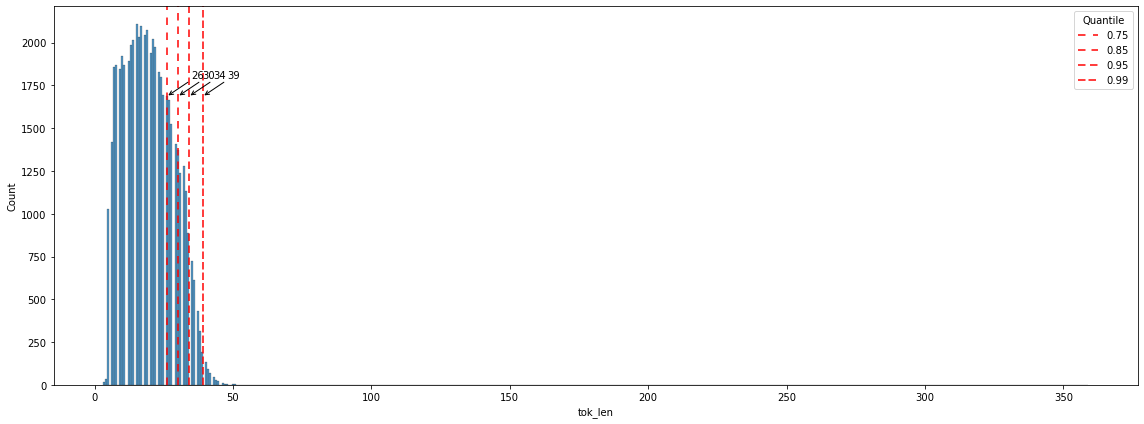

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

sns.histplot(x='tok_len', data=df_all, ax=ax)
max_val = max([p.get_height() for p in ax.patches])
for q, ls in zip([0.75, 0.85, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)), (0, (5, 3)), (0, (5, 2))]):
    qv = int(df_all['tok_len'].quantile(q))
    ax.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
    ax.annotate(
        qv,
        xy=(qv, max_val * 0.8),
        xytext=(qv + 9, max_val * 0.85),
        arrowprops=dict(arrowstyle="->", color='black'),
    )

ax.legend(title='Quantile')

fig.tight_layout()

### Label distribution

In [59]:
import seaborn as sns

df_all['labels'] = df_all['labels'].apply(lambda x: x.split(','))
df_all = df_all.explode('labels')
df_all = df_all.astype({'labels': 'int'})
df_all.head()

,text,labels,comment_id,split,text_len,tok_len
0,My favourite food is anything I didn't have to...,27,eebbqej,train,11,16
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,train,20,25
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,train,6,10
3,To make her feel threatened,14,ed7ypvh,train,5,7
4,Dirty Southern Wankers,3,ed0bdzj,train,3,7


In [60]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63812 entries, 0 to 54262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        63812 non-null  object
 1   labels      63812 non-null  int64 
 2   comment_id  63812 non-null  object
 3   split       63812 non-null  object
 4   text_len    63812 non-null  int64 
 5   tok_len     63812 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.4+ MB


Unique labels: [27  2 14  3 26 15  8 20  0  6  1  4  5 12 22  9 16 25  7 17 18 13 10 24
 11 23 21 19]


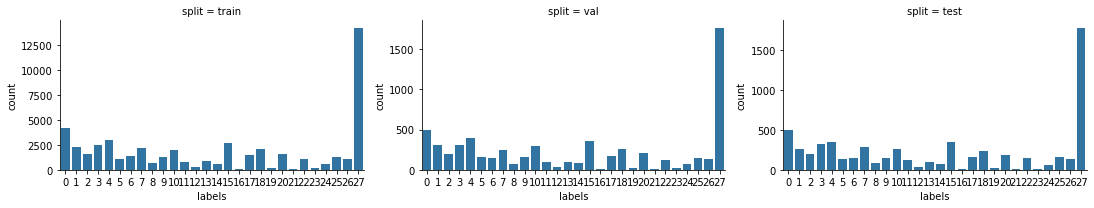

In [61]:
print(f'Unique labels: {df_all.labels.unique()}')

g = sns.FacetGrid(df_all, col="split", aspect=1.7, sharey=False)
g.map(sns.countplot, 'labels', order=range(0, 28))

# GoEmotions - sentiment grouped

In [9]:
from src.settings import DATA_DIR

DATA_DIR = DATA_DIR.joinpath('goemotions')

df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')

In [10]:
df_dev.head()

,text,labels,comment_id
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [7]:
emotions_path = DATA_DIR.joinpath('emotions.txt')

with emotions_path.open(mode='r') as f:
    emotions_list = [line.rstrip('\n') for line in f.readlines()]

emotions_list

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [8]:
import json

sentiment_map_path = DATA_DIR.joinpath('sentiment_mapping.json')

with sentiment_map_path.open(mode='r') as f:
    sentiment_mapper = json.load(f)

sentiment_mapper

{'positive': ['amusement',
  'excitement',
  'joy',
  'love',
  'desire',
  'optimism',
  'caring',
  'pride',
  'admiration',
  'gratitude',
  'relief',
  'approval'],
 'negative': ['fear',
  'nervousness',
  'remorse',
  'embarrassment',
  'disappointment',
  'sadness',
  'grief',
  'disgust',
  'anger',
  'annoyance',
  'disapproval'],
 'ambiguous': ['realization', 'surprise', 'curiosity', 'confusion'],
 'neutral': ['neutral']}

In [19]:
def map_emo_to_sentiment_label(labels: list[str]) -> list[str]:
    sentiment_labels_ids = set()
    for label_id in labels:
        label_str = emotions_list[int(label_id)]
        for idx, (sentiment, emotions) in enumerate(sentiment_mapper.items()):
            if label_str in emotions:
                sentiment_labels_ids.add(idx)   # add sentiment label id

    return [str(label) for label in sentiment_labels_ids]

In [22]:
df_dev['sent_labels'] = df_dev['labels'].apply(lambda x: ','.join(map_emo_to_sentiment_label(list(x.split(',')))))
df_train['sent_labels'] = df_train['labels'].apply(lambda x: ','.join(map_emo_to_sentiment_label(list(x.split(',')))))
df_test['sent_labels'] = df_test['labels'].apply(lambda x: ','.join(map_emo_to_sentiment_label(list(x.split(',')))))

In [24]:
df_test

,text,labels,comment_id,sent_labels
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,1
1,It's wonderful because it's awful. At not with.,0,ed5f85d,0
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,0
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,0
4,They got bored from haunting earth for thousan...,27,eem5uti,3
...,...,...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,15,efeeasc,0
5423,Well that makes sense.,4,ef9c7s3,0
5424,Daddy issues [NAME],27,efbiugo,3
5425,So glad I discovered that subreddit a couple m...,0,efbvgp9,0


In [25]:
df_train.to_csv(DATA_DIR.joinpath('train.tsv'), sep='\t', index=False)
df_dev.to_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t', index=False)
df_test.to_csv(DATA_DIR.joinpath('test.tsv'), sep='\t', index=False)